# Shearing as alternative to deskewing
In this notebook we take a look at a dataset acquired with a single objective light sheet micorscope with a tilted lightsheet, that needs to be deskewed before further processing. However, we will use shearing and cropping to retrieve a reconstructed image stack in orthogonal planes. This may be beneficial of deskewing as interpolation artifacts are minimized.

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow, imread, imsave


The image data shown is an organoid sample produced in Alf Honigmann's lab, MPI-CBG, imaged by Sebastian Bundschuh, MPI-CBG.

cl.OCLArray([[[127., 111., 103., ..., 116., 106., 130.],
        [116., 119., 112., ..., 111., 111., 109.],
        [104., 118., 109., ..., 109., 126., 122.],
        ...,
        [139., 118., 105., ..., 117., 108.,  94.],
        [129., 128., 147., ..., 118.,  99., 115.],
        [123., 120., 108., ..., 112., 118., 113.]],

       [[111., 118., 104., ..., 109., 111., 124.],
        [122., 130.,  99., ..., 139., 119., 109.],
        [131., 113., 120., ..., 117., 112., 126.],
        ...,
        [120., 112., 119., ...,  98., 121., 117.],
        [118., 118., 111., ..., 106., 113.,  98.],
        [122., 111., 125., ..., 124., 105., 106.]],

       [[117., 123., 115., ..., 108., 111., 133.],
        [112., 114., 125., ..., 112., 113., 114.],
        [119., 102., 117., ..., 121., 102., 117.],
        ...,
        [116., 119., 118., ..., 103., 106., 108.],
        [118., 119., 111., ..., 106.,  96., 100.],
        [116., 119., 109., ..., 105., 110., 107.]],

       ...,

       [[108., 128., 117., ..., 111., 117., 119.],
        [104., 105., 122., ..., 108., 107.,  88.],
        [132., 112., 116., ..., 108., 111., 124.],
        ...,
        [106., 111.,  99., ..., 103., 109.,  84.],
        [118., 103., 107., ..., 104., 107., 100.],
        [111., 108., 101., ..., 114.,  97., 119.]],

       [[117., 105., 117., ..., 122., 109., 116.],
        [113., 109., 119., ..., 102., 108.,  95.],
        [116., 119., 134., ..., 106., 102., 125.],
        ...,
        [106., 107., 119., ...,  94., 101., 132.],
        [113., 104., 104., ..., 106., 107., 109.],
        [108., 126., 109., ..., 112., 105., 100.]],

       [[102., 113., 118., ..., 115., 109., 116.],
        [119., 109., 129., ..., 109., 109., 113.],
        [106., 106., 127., ..., 119., 105., 106.],
        ...,
        [107.,  96., 103., ..., 110., 110., 104.],
        [111., 104., 102., ..., 112., 117., 107.],
        [103., 106.,  93., ..., 106., 107., 120.]]], dtype=float32)
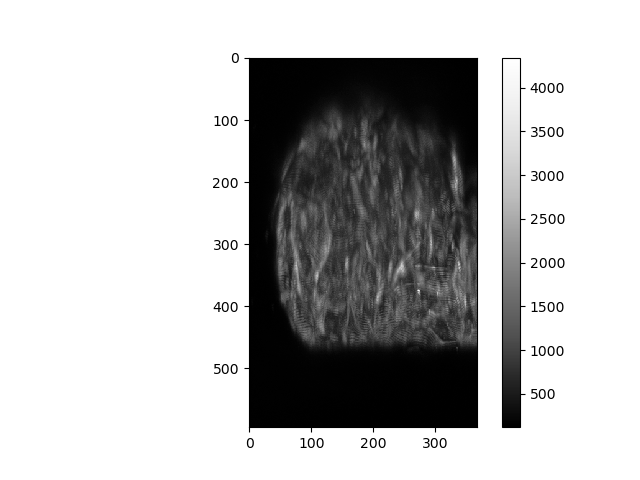
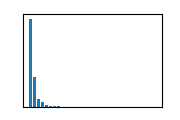

In [3]:
# Laod example data
input_image = imread("../../../clesperanto_example_data/Organoid_MMStack_Pos0.ome.tif")

cle.asarray(input_image)

cl.OCLArray([[101., 103., 103., ..., 103., 113., 121.],
       [119., 115., 105., ..., 105., 113., 103.],
       [114.,  92., 115., ..., 112., 102., 115.],
       ...,
       [ 97., 114.,  97., ..., 106., 112., 111.],
       [105., 105., 116., ..., 107., 106., 103.],
       [112., 127., 110., ..., 105., 121., 110.]], dtype=float32)
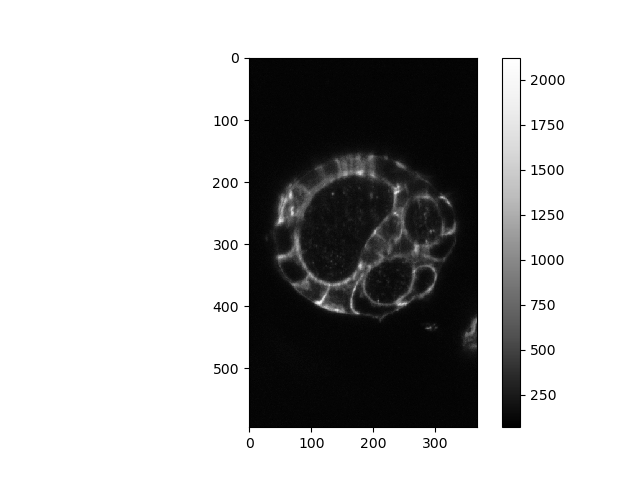
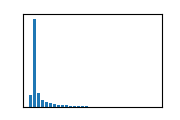

In [4]:
cle.asarray(input_image[60])

In [5]:
voxel_size_xy = 0.1950002
voxel_size_z = 0.5
deskewing_angle_in_degrees = 49

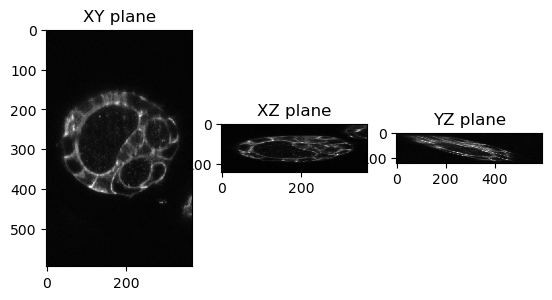

In [6]:
def view_stack(image):
    """
    View three center planes of the stack.
    """
    shape = image.shape
    
    fig, ax = plt.subplots(1, 3)

    cle.imshow(image[int(shape[0] / 2)], plot=ax[0])
    ax[0].set_title("XY plane")
    cle.imshow(image[:,int(shape[1] / 2)], plot=ax[1])
    ax[1].set_title("XZ plane")
    cle.imshow(image[:,:,int(shape[2] / 2)], plot=ax[2])
    ax[2].set_title("YZ plane")
    plt.show()

view_stack(input_image)

Obviously, there is a tilt in X direction visible in the YZ plane.

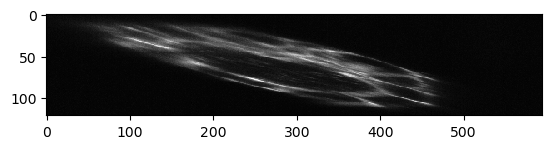

In [7]:
cle.imshow(input_image[:,:,int(input_image.shape[2] / 2)])

Next, we shear this dataset to get the z-planes in the right position again. Note, we are deactivating interpolation in thise example to avoid blurring introduced by interpolation. Depending on slice distance and deskewing/shearing angle, this might introduce artifacts visible as steps between slices.

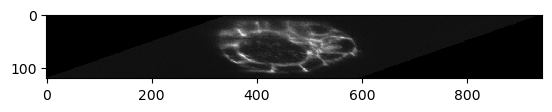

In [8]:
shear_angle = -(90 - deskewing_angle_in_degrees * voxel_size_xy / voxel_size_z)

# transform the image
transform = cle.AffineTransform3D()
transform.shear_in_x_plane(angle_y_in_degrees=shear_angle)
transformed_image = cle.affine_transform(input_image, 
                                         transform=transform, 
                                         auto_size=True,
                                         linear_interpolation=False)

cle.imshow(transformed_image[:,:,int(transformed_image.shape[2] / 2)])

## Cropping
Obviously there is some black background region around the organoid that we would like to avoid saving to disc. Hence, we crop out the organoid.

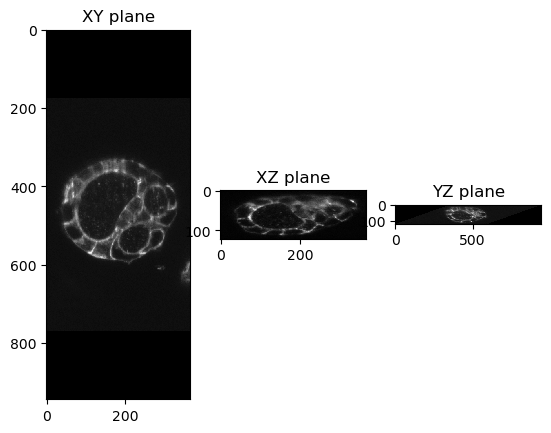

In [9]:
view_stack(transformed_image)

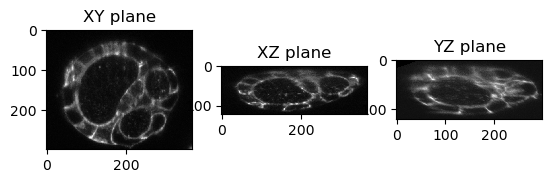

In [10]:
cropped = transformed_image[:, 300:600]

view_stack(cropped)